# Step 0: Load The Data

In [65]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

import csv

label2Name = {}
with open('./data/signnames.csv') as namesFile:
    nameReader = csv.reader(namesFile)
    for row in nameReader:
        label2Name[int(row[0])] = row[1]

# Step1: Dataset Summary & Exploration

## General numbers

In [103]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(list(y_train) + list(y_valid) + list(y_test)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


## Image samples

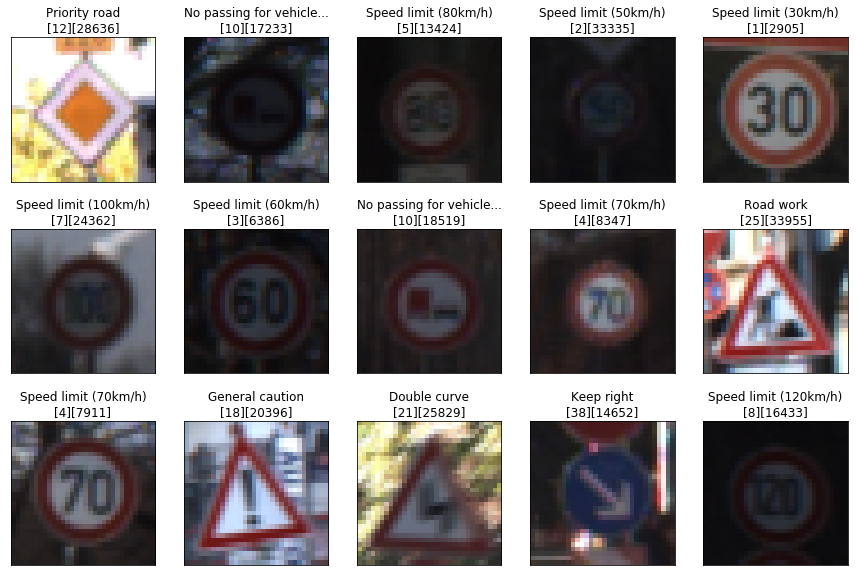

In [104]:
import random
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def exploreData(images, labels, translation):
    """
    Visualize a random selection of images from `images`. 
    Showing the index and the label on the image title as:
    SIGNAL_NAME
    [label value][index value]
    """
    imgLength = len(images)
    assert(imgLength == len(labels))
    columns = 5
    rows = 3    
    imgW, imgH, _ = images[0].shape
    fig, axes = plt.subplots(rows, columns, figsize=(15,10),
                         subplot_kw={'xticks': [], 'yticks': []})
   
    indexes = list(random.randint(0, imgLength) for r in range(columns * rows))
    labelLimit = 25
    for ax, index in zip(axes.flat, indexes):
        ax.imshow(images[index])
        label = labels[index]
        name = translation[label]
        if len(name) > labelLimit - 3:
            name = name[:labelLimit - 3] + '...'
        ax.set_title("{1}\n[{2}][{0}]".format(index, name, label))


exploreData(X_train, y_train, label2Name)    


## Label distribution

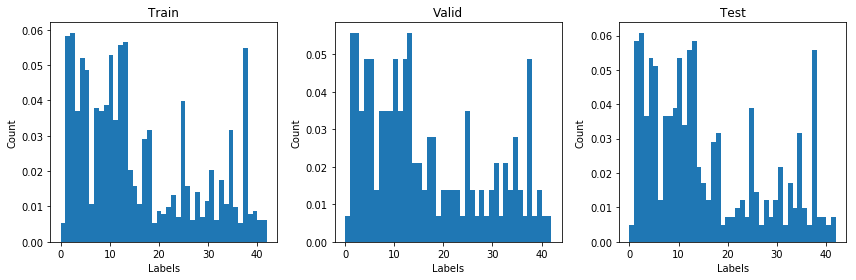

In [111]:
def plotLabelHistogram(labels, titles, numberOfLabels):
    """
    Plot the histogram of the list of `labels` using the `titles` as title for the graphs
    and the number of bins `numberOfLabels`.
    """
    nCols = len(labels)
    assert(nCols == len(titles))
    
    fig, axes = plt.subplots(ncols=nCols, figsize=(4*nCols, 4))
    for ax, label, title in zip(axes.flat, labels, titles):        
        n, bins, patches = ax.hist(label, numberOfLabels, normed=1)
        ax.set_xlabel('Labels')
        ax.set_ylabel('Count')
        ax.set_title(title)
        
    fig.tight_layout()
    plt.show()
    
plotLabelHistogram([y_train, y_valid, y_test], ['Train', 'Valid', 'Test'], n_classes)

# Step 2: Design and Test a Model Architecture

## Pre-processing

## Model Architecture

In [135]:
import tensorflow as tf

EPOCHS = 1

In [136]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b    
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [137]:
# Placeholders 
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Train, Validate and Test the Model¶

In [138]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [139]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, batchSize):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batchSize):
        batch_x, batch_y = X_data[offset:offset+batchSize], y_data[offset:offset+batchSize]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [140]:
from sklearn.utils import shuffle
def train(input, labels, valid_input, valid_labels):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        print("Training...")
        print()
        for i in range(EPOCHS):
            input, labels = shuffle(input, labels)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = input[offset:end], labels[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

            validation_accuracy = evaluate(valid_input, valid_labels, BATCH_SIZE)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

        saver.save(sess, './models/lenet')
        print("Model saved")

train(X_train, y_train, X_valid, y_valid)

Training...

EPOCH 1 ...
Validation Accuracy = 0.698

Model saved


# Step 3: Test a Model on New Images

# Step 4 (Optional): Visualize the Neural Network's State with Test Images